In [13]:
import pandas as pd
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json

torch.set_float32_matmul_precision('medium')


In [14]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 
    'Soil_Moisture', 'Soil_Temperature'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [15]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [16]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []

tscv = TimeSeriesSplit(n_splits=10)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.0005, patience=15, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TSMixerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=96,
        output_chunk_length=24,
        n_epochs=100,
        batch_size=72,
        dropout=0.45,
        ff_size=147,
        num_blocks=3,
        hidden_size=40,
        normalize_before=False,
        norm_type="LayerNormNoBias",
        activation="GELU",
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":7, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.004631076157876628, "weight_decay":5.055631463203692e-06},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=24,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
                'WMAPE': wmape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 759 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.278
Metric val_loss improved by 0.041 >= min_delta = 0.0005. New best score: 0.237
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.237. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                    52.552044    7.249279    5.863071    0.094407   
Precipitation_accumulated       0.535078    0.731490    0.661549 -207.929143   
Humidity                      639.081075   25.280053   21.817408   -1.024339   
Soil_Moisture              241200.119283  491.121288  383.655903   -1.113719   
Soil_Temperature               55.345178    7.439434    5.502229    0.338082   

                               SMAPE      WMAPE  
Temperature                32.643600  29.354867  
Precipitation_accumulated  30.421341  25.350566  
Humidity                   32.437927  34.537959  
Soil_Moisture               4.459933   4.496044  
Soil_Temperature           28.003375  26.673102  
O MSE desse fold foi 48389.5265313711

Fold 2

Treinando o modelo...
Train set: 1514 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.316
Metric val_loss improved by 0.027 >= min_delta = 0.0005. New best score: 0.289
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.288
Metric val_loss improved by 0.005 >= min_delta = 0.0005. New best score: 0.283
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.283. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                1.055566e+02    10.274074    9.180402 -1.574828   
Precipitation_accumulated  8.448928e+00     2.906704    1.966373 -0.795075   
Humidity                   6.562804e+02    25.617971   22.975469 -1.166478   
Soil_Moisture              1.045625e+06  1022.558086  840.791243 -0.049443   
Soil_Temperature           1.583105e+02    12.582148   10.635098 -2.087426   

                               SMAPE      WMAPE  
Temperature                47.494511  58.764173  
Precipitation_accumulated  41.380159  41.850808  
Humidity                   39.734756  30.361036  
Soil_Moisture              10.245604   9.975937  
Soil_Temperature           50.609564  67.329531  
O MSE desse fold foi 209310.72705828698

Fold 3

Treinando o modelo...
Train set: 2269 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 11.277
Metric val_loss improved by 0.040 >= min_delta = 0.0005. New best score: 11.237
Metric val_loss improved by 0.040 >= min_delta = 0.0005. New best score: 11.197
Metric val_loss improved by 0.005 >= min_delta = 0.0005. New best score: 11.192
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 11.186
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 11.184
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 11.183
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 11.182
Monitored metric val_loss did not improve in the last 15 records. Best score: 11.182. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connecto

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                5.246134e+01     7.243020     5.619638   
Precipitation_accumulated  2.003421e+05   447.595927   447.501779   
Humidity                   2.559273e+02    15.997728    12.443217   
Soil_Moisture              4.131433e+06  2032.592621  1931.269528   
Soil_Temperature           5.578369e+01     7.468848     5.904453   

                                    R2       SMAPE      WMAPE  
Temperature                  -0.680672   40.711577  32.297045  
Precipitation_accumulated -2095.303446  192.940778  98.201003  
Humidity                     -1.559927   17.671813  14.815139  
Soil_Moisture               -15.885777   25.292485  28.717767  
Soil_Temperature             -0.698514   44.666845  35.167479  
O MSE desse fold foi 866427.8102508539

Fold 4

Treinando o modelo...
Train set: 3024 samples
Validation set: 7

Metric val_loss improved. New best score: 0.143
Metric val_loss improved by 0.030 >= min_delta = 0.0005. New best score: 0.113
Metric val_loss improved by 0.023 >= min_delta = 0.0005. New best score: 0.090
Metric val_loss improved by 0.009 >= min_delta = 0.0005. New best score: 0.081
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.078
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.075
Metric val_loss improved by 0.007 >= min_delta = 0.0005. New best score: 0.068
Metric val_loss improved by 0.004 >= min_delta = 0.0005. New best score: 0.065
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.065. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_c

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    23.841407    4.882766    4.164126   
Precipitation_accumulated     493.629190   22.217767   21.360265   
Humidity                       66.732685    8.169008    6.748571   
Soil_Moisture              153854.384858  392.242763  303.940004   
Soil_Temperature               23.125334    4.808881    4.188726   

                                     R2      SMAPE      WMAPE  
Temperature               -5.989867e+00  28.222174  26.315362  
Precipitation_accumulated -5.599262e+06   4.547852   4.662358  
Humidity                  -3.155146e+00   7.642782   7.867115  
Soil_Moisture             -4.259278e+02   4.659629   4.768208  
Soil_Temperature          -4.150574e+00  28.313596  26.378103  
O MSE desse fold foi 30892.342694926243

Fold 5

Treinando o modelo...
Train set: 3779 samples
Validation set: 755 sa

Metric val_loss improved. New best score: 0.104
Metric val_loss improved by 0.024 >= min_delta = 0.0005. New best score: 0.080
Metric val_loss improved by 0.025 >= min_delta = 0.0005. New best score: 0.055
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.049
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.046
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.045
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.045. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   13.280352    3.644222    3.557495     -4.705823   
Precipitation_accumulated      8.431595    2.903721    2.604725 -21184.138318   
Humidity                      25.315363    5.031437    4.442572     -2.399916   
Soil_Moisture              20118.993836  141.841439  118.318620     -0.516483   
Soil_Temperature              10.629855    3.260346    3.139631     -5.767103   

                               SMAPE      WMAPE  
Temperature                28.523152  32.951118  
Precipitation_accumulated   0.569916   0.568496  
Humidity                    4.980427   4.958152  
Soil_Moisture               1.899531   1.901360  
Soil_Temperature           25.032897  28.725090  
O MSE desse fold foi 4035.330200219339

Fold 6

Treinando o modelo...
Train set: 4534 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.047
Metric val_loss improved by 0.009 >= min_delta = 0.0005. New best score: 0.038
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.036
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.033
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.028
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.028. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performa

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    1.999350    1.413984    1.250148   -3.851742   
Precipitation_accumulated     16.477954    4.059305    3.658160 -696.197142   
Humidity                      44.006482    6.633738    5.817755   -7.334514   
Soil_Moisture              36118.096954  190.047618  149.903444   -0.080581   
Soil_Temperature               1.476603    1.215156    1.082024   -8.260488   

                               SMAPE      WMAPE  
Temperature                14.105563  13.246349  
Precipitation_accumulated   0.794993   0.797850  
Humidity                    6.454171   6.278784  
Soil_Moisture               2.550228   2.543398  
Soil_Temperature           11.598217  10.951327  
O MSE desse fold foi 7236.411468560271

Fold 7

Treinando o modelo...
Train set: 5289 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.039
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.039. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    4.732303    2.175386    1.882685    -2.061689   
Precipitation_accumulated     28.479346    5.336604    4.830027 -1953.544931   
Humidity                     151.226379   12.297413   11.174995    -4.392312   
Soil_Moisture              20004.169133  141.436096  109.644410    -5.052687   
Soil_Temperature               2.895174    1.701521    1.491012    -2.747071   

                               SMAPE      WMAPE  
Temperature                23.903136  25.883044  
Precipitation_accumulated   1.059893   1.053083  
Humidity                   12.561094  13.202140  
Soil_Moisture               1.928182   1.908984  
Soil_Temperature           17.234463  18.254068  
O MSE desse fold foi 4038.300466836327

Fold 8

Treinando o modelo...
Train set: 6044 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.113
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 0.110
Metric val_loss improved by 0.009 >= min_delta = 0.0005. New best score: 0.102
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 0.100
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 0.097
Metric val_loss improved by 0.004 >= min_delta = 0.0005. New best score: 0.094
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.093
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.093. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have ma

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE          R2  \
Temperature                5.011165e+00     2.238563     1.742727    0.106659   
Precipitation_accumulated  1.713671e+01     4.139651     3.995410 -183.439739   
Humidity                   2.228980e+02    14.929770    10.853916   -0.986237   
Soil_Moisture              2.258115e+06  1502.702630  1129.278122   -0.496504   
Soil_Temperature           8.682258e+00     2.946567     2.382808   -0.771533   

                               SMAPE      WMAPE  
Temperature                35.708118  32.138986  
Precipitation_accumulated   0.871212   0.867139  
Humidity                   12.894118  12.756301  
Soil_Moisture              16.191457  16.309154  
Soil_Temperature           55.579860  55.020116  
O MSE desse fold foi 451673.7847285698

Fold 9

Treinando o modelo...
Train set: 6799 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.120
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.114
Metric val_loss improved by 0.013 >= min_delta = 0.0005. New best score: 0.101
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.100
Metric val_loss improved by 0.015 >= min_delta = 0.0005. New best score: 0.084
Metric val_loss improved by 0.004 >= min_delta = 0.0005. New best score: 0.080
Metric val_loss improved by 0.014 >= min_delta = 0.0005. New best score: 0.067
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.065
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.064
Metric val_loss improved by 0.005 >= min_delta = 0.0005. New best score: 0.059
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.057
Metric val_loss improved by 0.005 >= min_delta = 0.0005. New best score: 0.053
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 0.050
Metr

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    6.995949    2.644986    1.992932    0.562191   
Precipitation_accumulated    211.285965   14.535679   12.844971 -142.501516   
Humidity                      94.082722    9.699625    7.445581    0.108475   
Soil_Moisture              44393.220133  210.696987  178.739468  -14.727271   
Soil_Temperature              13.135348    3.624272    3.070009   -1.320558   

                               SMAPE      WMAPE  
Temperature                39.392794  29.175315  
Precipitation_accumulated   2.817003   2.769278  
Humidity                    8.391726   8.045602  
Soil_Moisture               2.084257   2.078036  
Soil_Temperature           81.899146  53.759609  
O MSE desse fold foi 8943.744023375311

Fold 10

Treinando o modelo...
Train set: 7554 samples
Validation set: 755 samples


Metric val_loss improved. New best score: 0.145
Metric val_loss improved by 0.061 >= min_delta = 0.0005. New best score: 0.084
Metric val_loss improved by 0.020 >= min_delta = 0.0005. New best score: 0.064
Metric val_loss improved by 0.014 >= min_delta = 0.0005. New best score: 0.050
Metric val_loss improved by 0.004 >= min_delta = 0.0005. New best score: 0.046
Metric val_loss improved by 0.005 >= min_delta = 0.0005. New best score: 0.041
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.040
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.040. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have ma

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                   13.892766    3.727300    2.941769     0.495525   
Precipitation_accumulated     23.915868    4.890385    4.293080 -3465.281047   
Humidity                     150.364402   12.262316   10.233306    -0.061401   
Soil_Moisture              15772.922366  125.590296  107.230387    -3.501702   
Soil_Temperature               3.618536    1.902245    1.521186     0.638394   

                               SMAPE      WMAPE  
Temperature                27.294113  23.427297  
Precipitation_accumulated   0.921816   0.921156  
Humidity                   12.464909  12.643926  
Soil_Moisture               1.221733   1.229542  
Soil_Temperature           15.067284  13.634919  
O MSE desse fold foi 3192.942787725893
O melhor fold (baseado no menor MSE) foi 10
A média dos MSE de todos os folds foi 163414.0

In [17]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TSMixerModel(output_chunk_shift=0, hidden_size=40, ff_size=147, num_blocks=3, activation=GELU, dropout=0.45, norm_type=LayerNormNoBias, normalize_before=False, use_static_covariates=True, model_name=model_10, input_chunk_length=96, output_chunk_length=24, n_epochs=100, batch_size=72, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f1d008bc3e0>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 7, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.004631076157876628, 

In [18]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Soil_Moisture', 'Soil_Temperature', 'fold'],
      dtype='object', name='component')


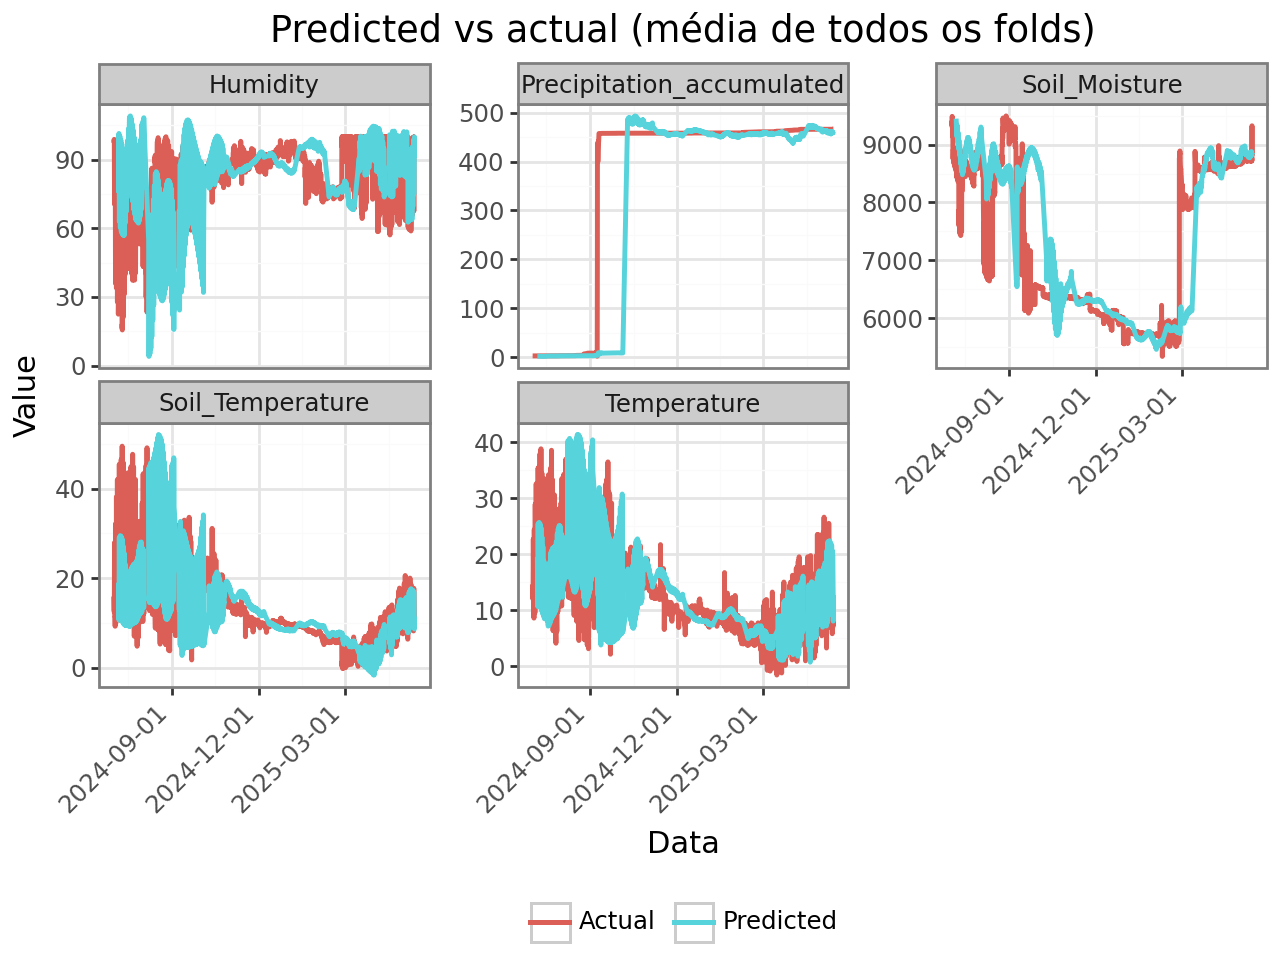

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


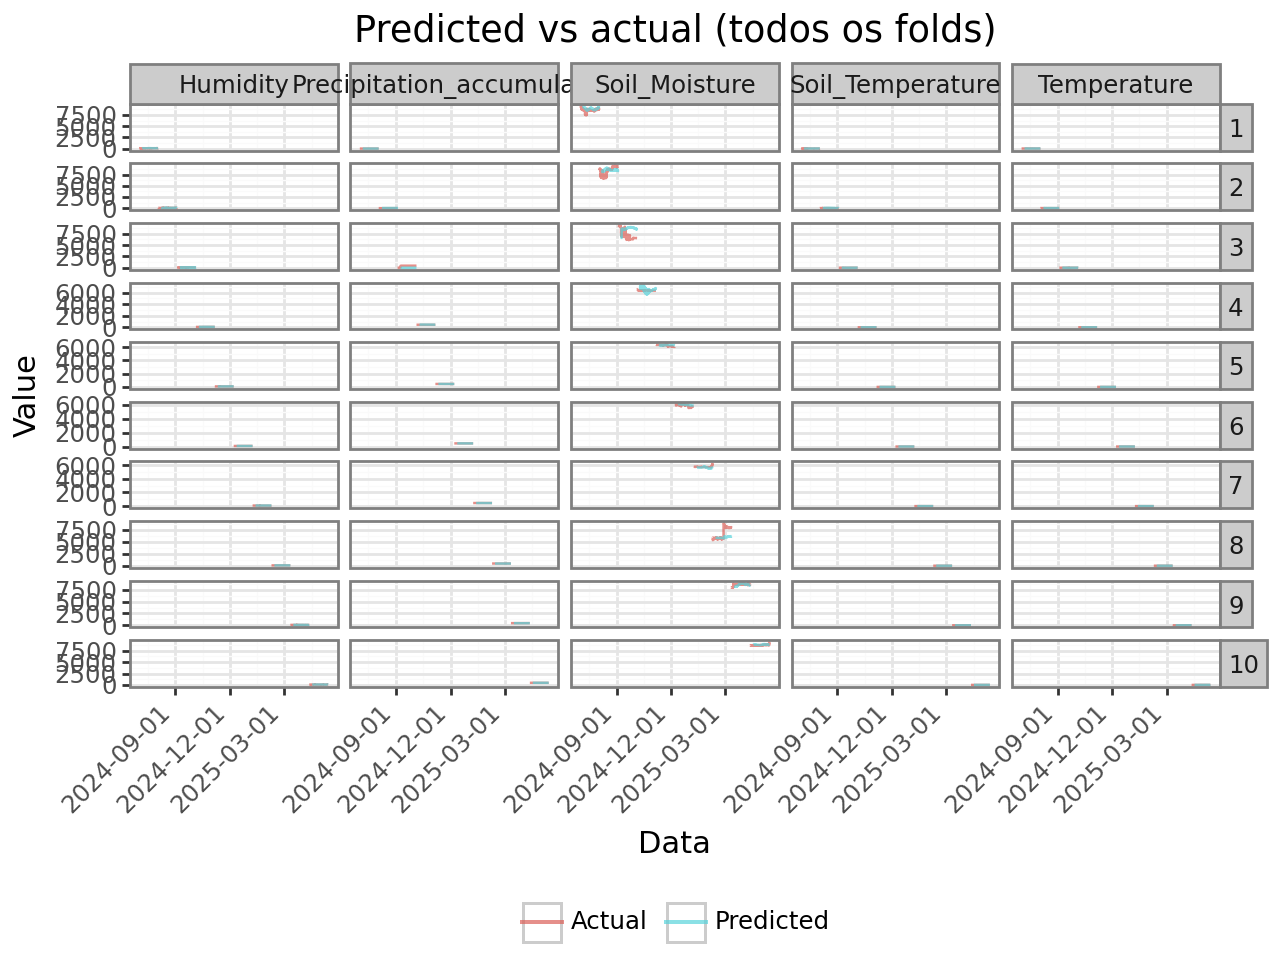

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_8366/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


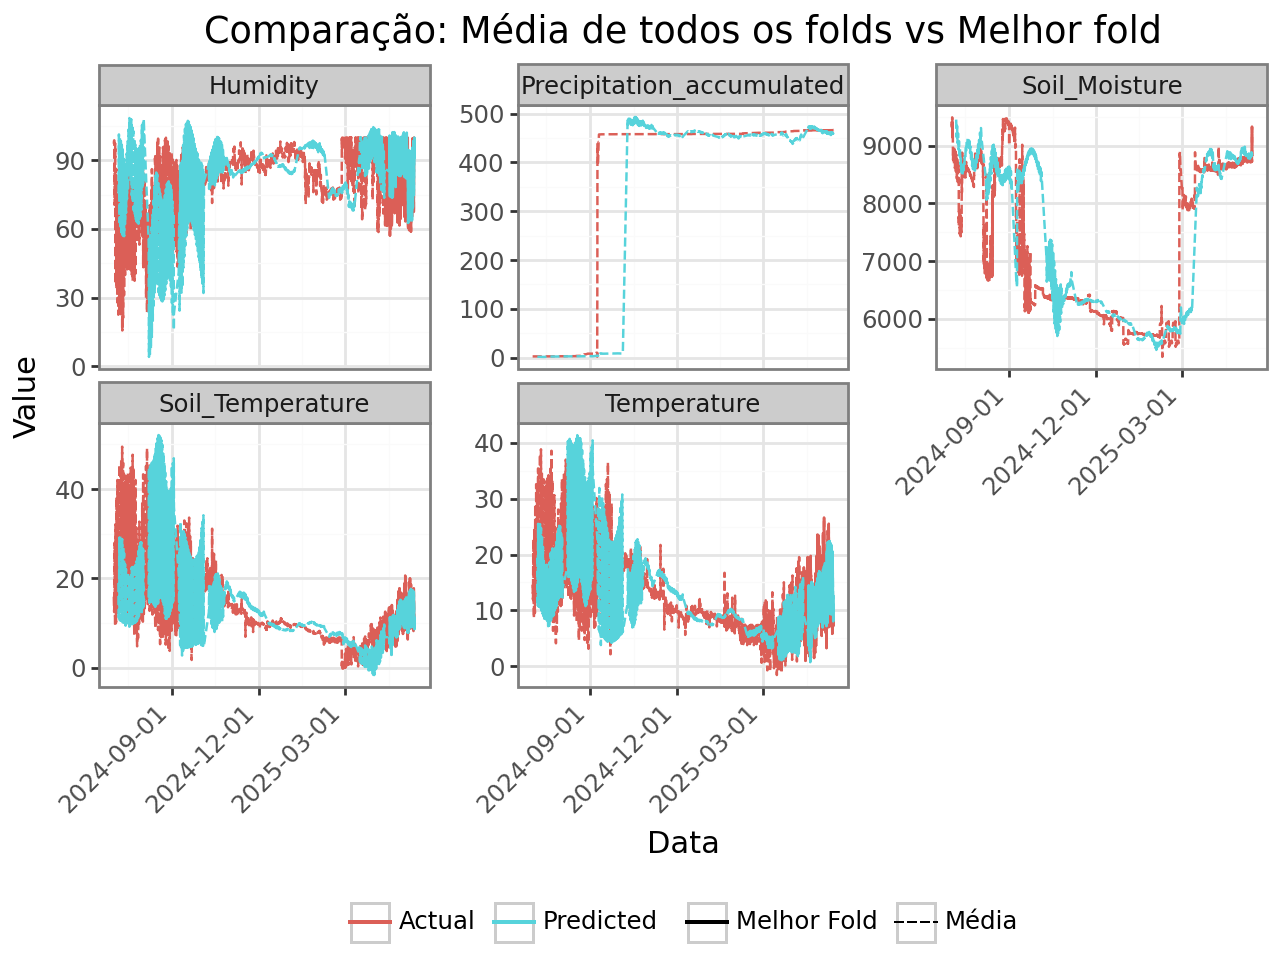

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [19]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [20]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
